In [119]:
import cv2
import json
from src.lib.utils.pnp.cuboid_pnp_shell import pnp_shell
import matplotlib.pyplot as plt
import numpy as np
from src.lib.opts import opts
from itertools import permutations
import copy
import math
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [120]:
# OPT:
opt = opts()
opt.nms = True
opt.obj_scale = True
opt.c = "cereal_box" # category
    
# Meta: 
# Load data from the PKL file
with open('cameraMatrix.pkl', 'rb') as f:
    camera = pickle.load(f)

print("Camera: \n", camera)

Camera: 
 [[3.96770805e+03 0.00000000e+00 2.48874091e+03]
 [0.00000000e+00 3.94294572e+03 2.11216245e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [121]:
# Take GT as imput:
with open('data/synthetic_data/real_test/anno.json', 'r') as f:
    data = json.load(f)

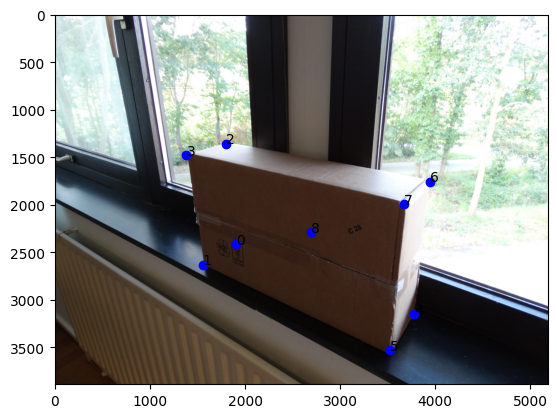

Scale object [1.7413793103448276, 1, 0.41379310344827586]


In [122]:
# first test with GT cereal:
img_id = 1
img_gt = data[img_id]
size = img_gt["whd"]
points =  img_gt["projection"]
w_points = img_gt["world"]


image = plt.imread("data/synthetic_data/real_test/" + str(img_id) + ".jpg")
plt.imshow(image)

for i, p in enumerate(points):
     plt.plot(p[0],p[1], 'bo')
     plt.text(p[0], p[1], f"{i}")

plt.show()

print("Scale object", size)

In [123]:
bbox = {'kps': points[:8], "obj_scale": size}
print("width", image.shape[1],"height", image.shape[0])
meta = {"width": image.shape[1],"height": image.shape[0], "camera_matrix": camera}
print("size: ", size)

width 5184 height 3888
size:  [1.7413793103448276, 1, 0.41379310344827586]


In [124]:
projected_points, point_3d_cam, scale, points_ori, bbox = pnp_shell(opt, meta, bbox, points[:8], size, OPENCV_RETURN=False)
gt_3dcam = bbox["kps_3d_cam"]

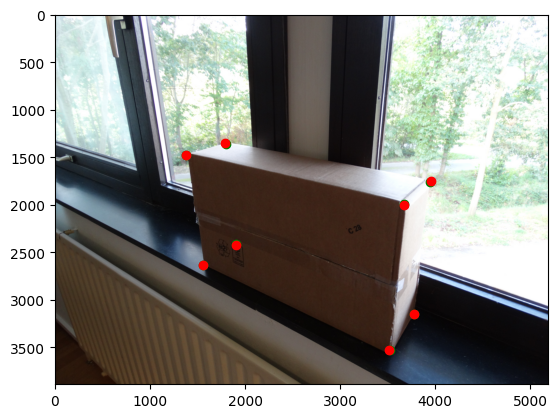

In [125]:
plt.imshow(image)

# GT
for p in points[:8]:
     plt.plot(int(p[0]),int(p[1]), 'go')

# After PnP  
for p in bbox["projected_cuboid"]:
     plt.plot(int(p[0]),int(p[1]), 'ro')

plt.show()

In [126]:
# Take GT as imput:
with open('exp/real_test/1.json', 'r') as f:
    data = json.load(f)

In [137]:
# Provided data with invalid points
kps_displacement_mean = data["objects"][0]["kps_displacement_mean"]
points = [(kps_displacement_mean[i], kps_displacement_mean[i + 1]) for i in range(0, len(kps_displacement_mean), 2)]
size = data["objects"][0]["obj_scale"]
print("Estimated: ", size)
# size = [1.7413793103448276, 1, 0.41379310344827586]

# Example 3D world
bbox = {'kps': points, "obj_scale": size}
meta = {"width": image.shape[1],"height": image.shape[0], "camera_matrix": camera}

projected_points, point_3d_cam, scale, points_ori, bbox = pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)

Estimated:  [2.4118058681488037, 1.0081398487091064, 1.2605838775634766]


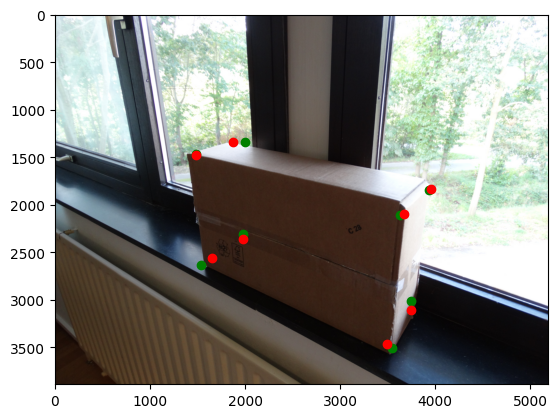

In [138]:
plt.imshow(image)

for p in points:
     plt.plot(int(p[0]),int(p[1]), 'go')

# After PnP  
for p in bbox["projected_cuboid"]:
     plt.plot(int(p[0]),int(p[1]), 'ro')
plt.show()

In [139]:
from src.tools.objectron_eval.objectron.dataset.box import Box as Boxcls
from src.tools.objectron_eval.objectron.dataset.iou import IoU

In [140]:
gt_box = Boxcls(gt_3dcam) # doet pnp op gt pixel coördinaten -> om de 3D wereld coordinaten te krijgen
detect_box = Boxcls(point_3d_cam)

iou = IoU(detect_box, gt_box) # calculate IoU:
result = iou.iou()
print(result)

0.45454357257926803


In [141]:
trans = gt_box.vertices[0] - detect_box.vertices[0]
translated = []

for i in range(len(detect_box.vertices)):
    translated.append(detect_box.vertices[i]+trans)
    
translated = np.array(translated)
translated_box = Boxcls(translated)

In [142]:
iou = IoU(translated_box, gt_box) # calculate IoU:
result = iou.iou()
print(result)

0.9191895694905416
